# Диффузия двух веществ



## Инициализация клеток

In [1]:
import numpy as np

# Параметры области и схемы
N = 16                                 # базовый размер по высоте (и половине ширины)
H, W = N, 2 * N                        # высота H и ширина W прямоугольной решётки
alpha = 0.2                            # коэффициент диффузии-схемы (D * dt / h^2)

speed = 1.0                            # множитель скорости анимации (1.0 — базовая)
base_interval = 50                     # базовый интервал между кадрами в миллисекундах
interval_ms = int(base_interval / speed)  # реальный интервал между кадрами с учётом speed

block_size = 4                         # размер квадрата с веществом

u1 = np.zeros((H, W), dtype=float)     # поле концентраций первого вещества
u2 = np.zeros((H, W), dtype=float)     # поле концентраций второго вещества

# Центры квадратов
cy = H // 2                            # вертикальный центр области
r0 = cy - block_size // 2              # верхняя граница квадрата по вертикали
r1 = r0 + block_size                   # нижняя граница квадрата по вертикали

cx_left = N // 2                       # горизонтальный центр левой половины области
c0_left = cx_left - block_size // 2    # левая граница левого квадрата
c1_left = c0_left + block_size         # правая граница левого квадрата
u1[r0:r1, c0_left:c1_left] = 1.0       # заполняем левый квадрат первым веществом

cx_right = N + N // 2                  # горизонтальный центр правой половины области
c0_right = cx_right - block_size // 2  # левая граница правого квадрата
c1_right = c0_right + block_size       # правая граница правого квадрата
u2[r0:r1, c0_right:c1_right] = 1.0     # заполняем правый квадрат вторым веществом

# Визуализация

## Логарифмирование

Логарифмирование значений цвета для красоты:

$$
v=\frac{\ln(1+ku)​}{\ln(1+k)} 
$$

Такое преобразование делает тусклые клетки более яркими, но диапазон остается $[0, 1]$.

Будем использовать `np.log1p(x)`вместо `np.log(1 + x)`, чтобы меньше терять точность, когда `x` очень мал. `np.log1p(x)` вычисляет $\ln(1+x)$, но численно устойчиво для маленьких $x$.



In [2]:
def log_scale(u, eps=1e-6, k=50.0):
    u_clip = np.clip(u, 0.0, None)          # обрезка значений снизу
    v = np.log1p(k * u_clip) / np.log1p(k)
    return v

## Концентрации -> цвета

In [3]:
def make_rgb(u1, u2, base_gray=0.1):
    """Преобразуем два поля концентраций в RGB-картинку так,
    чтобы пиксели с веществами не были темнее фонового серого.
    """
    # логарифмическое шкалирование концентраций
    r = log_scale(u1)  # [0, 1]
    b = log_scale(u2)  # [0, 1]

    # "чистый" цвет от веществ (без фона)
    color = np.zeros((H, W, 3), dtype=float)
    color[..., 0] = r      # красный канал — вещество 1
    color[..., 2] = b      # синий канал — вещество 2

    # добавляем цвет поверх серого фона:
    # при r=b=0 получаем ровно [base_gray, base_gray, base_gray],
    # при r или b → 1 получаем до [1, 0, 1] и т.д.
    rgb = base_gray + (1.0 - base_gray) * color

    return rgb


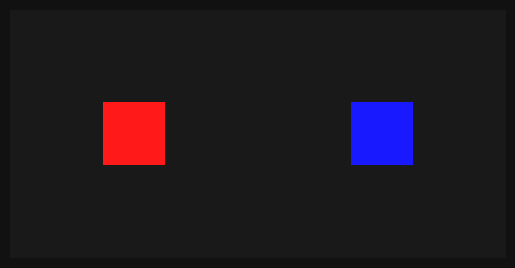

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
fig, ax = plt.subplots()
img = make_rgb(u1, u2)
im = ax.imshow(img, interpolation="nearest")
ax.set_axis_off()
fig.patch.set_facecolor("#111111")
plt.show()

# Шаг диффузии

Для того, чтобы вычислять кросс-корреляцию, можно воспользоваться функцией `correlate2d()` из модуля `signal` библиотеки `scipy`. В качестве граничного условия будем использовать условие Неймана, чтобы моделировать ограниченное пространство. Для этого зададим параметры `mode='same'`, чтобы результатом преобразования была матрица того же размера, что и входная матрица, `boundary='symm'`, чтобы при вычислении значений на границах матрицы добавлялась рамка вокруг всей матрицы, значения которых совпадают с граничными значениями.

In [ ]:
import numpy as np
from scipy.signal import correlate2d

def diffusion_step_box(u, D, kernel=None):
    """
    Один шаг диффузии в замкнутом ящике (без потока через границы).
    Условия Неймана: производная по нормали на границе = 0.

    Реализовано через кросс-корреляцию с ядром лапласиана
    и симметричное продолжение массива (boundary='symm'),
    что эквивалентно "зеркальным" призрачным ячейкам.
    """
    if kernel is None:
        laplacian_kernel = np.array([
            [0.0,  1.0, 0.0],
            [1.0, -4.0, 1.0],
            [0.0,  1.0, 0.0]
        ], dtype=float)

    laplacian = correlate2d(u, laplacian_kernel,
                            mode='same',      # размер выхода = размер входа
                            boundary='symm')  # зеркальное продолжение (Neumann)
    return u + D * laplacian

Альтернативный вариант без `scipy`:

In [6]:
# def diffusion_step_box(u, D):
#     """
#     Один шаг диффузии в замкнутом ящике (без потока через границы).
#     Условия Неймана: производная по нормали на границе = 0.
#     Реализуем через зеркальное расширение массива (mode='edge').
#     """
#     # Добавляем по одному призрачному слою с каждой стороны,
#     # где значения на границе просто копируются.
#     u_p = np.pad(u, pad_width=1, mode='edge')

#     center = u_p[1:-1, 1:-1]
#     up     = u_p[:-2, 1:-1]
#     down   = u_p[2:, 1:-1]
#     left   = u_p[1:-1, :-2]
#     right  = u_p[1:-1, 2:]

#     laplacian = up + down + left + right - 4 * center
#     return u + D * laplacian

# Симуляция

In [ ]:
from matplotlib.animation import FuncAnimation

steps = 500                            # количество шагов анимации

u1_anim = u1.copy()
u2_anim = u2.copy()

%matplotlib qt
fig, ax = plt.subplots(figsize=(12, 6))

img = make_rgb(u1_anim, u2_anim)
im = ax.imshow(img, interpolation="nearest")
ax.set_axis_off()
fig.patch.set_facecolor("#111111")
ax.set_facecolor("#111111")

def update(frame, u1_anim, u2_anim, im, ax):
    # считаем новые значения
    u1_new = diffusion_step_box(u1_anim, alpha)
    u2_new = diffusion_step_box(u2_anim, alpha)

    # обновляем массивы
    u1_anim[:] = u1_new
    u2_anim[:] = u2_new

    img = make_rgb(u1_anim, u2_anim)
    im.set_data(img)
    return [im]

ani = FuncAnimation(
    fig,
    update,
    frames=steps,
    fargs=(u1_anim, u2_anim, im, ax), 
    interval=interval_ms,
    blit=False
)

plt.show()